
# 📌 Importing Libraries

In [2]:
import numpy as np
import os
import zipfile
import requests
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import random

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import layers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Lambda

import cv2

In [3]:
IMG_SIZE = 105  # Image size for resizing omniglot dataset
# IMG_SIZE = 224  # Required for ResNet50
BATCH_SIZE = 32
EPOCHS = 5

# 🔹 Step 1: Load & Explore the Dataset

In [4]:
# URL of the Omniglot dataset
url = "https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip"

def download_and_extract(url, extract_path="omniglot_data"):
    """Download and extract the Omniglot dataset."""
    os.makedirs(extract_path, exist_ok=True)
    zip_path = os.path.join(extract_path, "images_background.zip")

    # Download the dataset
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))

    with open(zip_path, "wb") as file, tqdm(
        desc="Downloading Omniglot", total=total_size, unit="B", unit_scale=True
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            file.write(data)
            bar.update(len(data))

    # Extract the dataset
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

    print(f"Dataset extracted to: {extract_path}")

    # Remove zip file after extraction
    os.remove(zip_path)

# Load the dataset
download_and_extract(url)



Dataset extracted to: omniglot_data


## 📌 Step 1.2: Creating Smallest Dataset

In [6]:
# Function to get image paths and labels (only alphabet labels)
def get_image_paths_and_labels(data_path="omniglot_data/images_background", num_alphabets=4):
    """Retrieve image paths and labels from 10 random alphabets, excluding specific ones."""
    exclude_alphabets = {"Blackfoot_(Canadian_Aboriginal_Syllabics)", "Bengali", "Balinese"}
    all_alphabets = [a for a in os.listdir(data_path) if a not in exclude_alphabets]

    # Randomly select 4 alphabets
    selected_alphabets = random.sample(all_alphabets, num_alphabets)

    image_paths = []
    labels = []

    for alphabet in selected_alphabets:
        char_folders = os.listdir(os.path.join(data_path, alphabet))
        for char_folder in char_folders:
            char_path = os.path.join(data_path, alphabet, char_folder)
            images = [os.path.join(char_path, img) for img in os.listdir(char_path)]

            image_paths.extend(images)
            labels.extend([alphabet for _ in images])  # Use only alphabet as label

    return image_paths, labels

# Get dataset paths and labels
image_paths, labels = get_image_paths_and_labels()

print(f"Total images: {len(image_paths)}, Total labels: {len(set(labels))}")
print(set(labels))

Total images: 2760, Total labels: 4
{'Sanskrit', 'Tifinagh', 'Tagalog', 'Greek'}


## 📌 Step 1.3: Visualize some samples

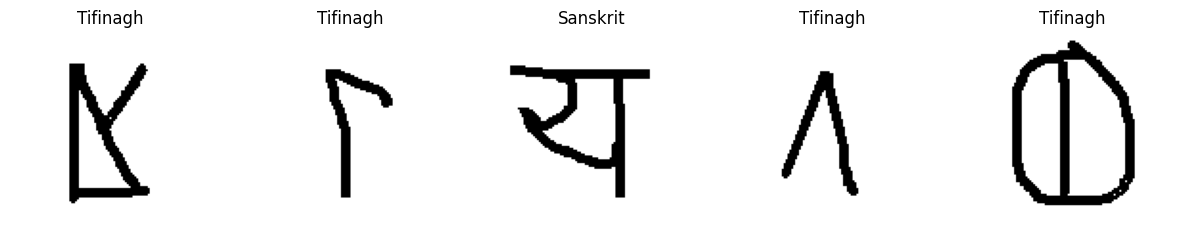

In [7]:
# Visualize some samples
def plot_sample_images(image_paths, labels, n_samples=5):
    """Plot sample character images from Omniglot."""
    fig, axes = plt.subplots(1, n_samples, figsize=(15, 5))
    sample_indices = random.sample(range(len(image_paths)), n_samples)

    for i, idx in enumerate(sample_indices):
        img = Image.open(image_paths[idx]).convert("L")
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(labels[idx])
        axes[i].axis("off")
    plt.show()

# Show sample images
plot_sample_images(image_paths, labels)

# 🔹 Step 2: Preprocessing

## 📌 Step 2.1: Load Image

In [8]:
def load_image(image_path):
    if not os.path.isfile(image_path):
        print(f"Skipped: {image_path} is a directory.")
        return None  # Skip directories

    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize to [0, 1]
    return image


## 📌 Step 2.2: Prepare data

In [9]:
def prepare_data(image_paths):
    images = []
    valid_paths = []
    for path in image_paths:
        img = load_image(path)
        if img is not None:
            images.append(img)
            valid_paths.append(path)
    return np.array(images), valid_paths

X, valid_paths = prepare_data(image_paths)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform([path.split('/')[-3] for path in valid_paths])
print(y)

[3 3 3 ... 0 0 0]


## 📌 Step 2.3: Creating Pairs

In [10]:
def create_pairs(images, labels):
    pairs = []
    pair_labels = []
    num_classes = len(np.unique(labels))

    # Create pairs
    for idx in range(len(images)):
        current_img = images[idx]
        current_label = labels[idx]

        # Positive pair
        pos_idx = np.random.choice(np.where(labels == current_label)[0])
        pos_img = images[pos_idx]
        pairs.append([current_img, pos_img])
        pair_labels.append(1)

        # Negative pair
        neg_label = (current_label + np.random.randint(1, num_classes)) % num_classes
        neg_idx = np.random.choice(np.where(labels == neg_label)[0])
        neg_img = images[neg_idx]
        pairs.append([current_img, neg_img])
        pair_labels.append(0)

    return np.array(pairs), np.array(pair_labels)

pairs, pair_labels = create_pairs(X, y)
del X, y, valid_paths

# 🔹 Srep 3 : Siamese Network

## 📌 Step 3.1: Feature Extractor

In [11]:
def build_feature_extractor():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Freeze ResNet50 layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add trainable layers on top
    x = layers.GlobalAveragePooling2D()(base_model.output)
    # x = layers.Dense(256, activation='relu', trainable=True)(x)
    # x = layers.Dropout(0.5)(x)
    # x = layers.Dense(128, activation='relu', trainable=True)(x)
    x = layers.Dense(64, activation='relu', trainable=True)(x)
    
    feature_extractor = Model(inputs=base_model.input, outputs=x)
    return feature_extractor


## 📌 Step 3.2: Using Contrastive Loss

In [12]:
# first
'''
def contrastive_loss(y_true, y_pred, margin=1.0):
    squared_loss = tf.square(y_pred)
    margin_loss = tf.square(tf.maximum(margin - y_pred, 0))
    loss = (1 - y_true) * squared_loss + y_true * margin_loss
    return tf.reduce_mean(loss)

def euclidean_distance(vectors):
    x, y = vectors
    return tf.norm(x - y, axis=-1, keepdims=True)
'''


# Second
'''
def contrastive_loss(y_true, y_pred, margin=1.0):
    """Contrastive Loss function for Siamese Networks."""
    y_true = K.cast(y_true, K.floatx())
    squared_pred = K.square(y_pred)
    margin_squared = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * squared_pred + (1 - y_true) * margin_squared)

def euclidean_distance(vectors):
    """Compute Euclidean distance between two feature vectors."""
    x, y = vectors
    return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True))
'''

# final

def contrastive_loss(y_true, y_pred, margin=1.0):
    """Contrastive Loss function with numerical stability."""
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.clip(y_pred, K.epsilon(), 1.0)  # Ensure y_pred is not too close to zero
    squared_pred = K.square(y_pred)
    margin_squared = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * squared_pred + (1 - y_true) * margin_squared)

def euclidean_distance(vectors):
    """Compute Euclidean distance with numerical stability."""
    x, y = vectors
    return K.sqrt(K.sum(K.square(x - y), axis=-1, keepdims=True) + K.epsilon())

## 📌 Step 3.3: Architecture of Siamese

In [13]:
def build_siamese_network():
    feature_extractor = build_feature_extractor()

    input_a = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    input_b = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    feat_a = feature_extractor(input_a)
    feat_b = feature_extractor(input_b)

    # Compute Euclidean Distance
    distance = Lambda(euclidean_distance)([feat_a, feat_b])
    # output = layers.Dense(1)(distance)

    siamese_network = Model(inputs=[input_a, input_b], outputs=distance)
    
    # Compile the model with contrastive loss
    siamese_network.compile(optimizer='adam', loss=contrastive_loss)
    
    return siamese_network

# Build the Siamese network with contrastive loss
siamese_network = build_siamese_network()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
siamese_network.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 105, 105, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 105, 105, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ (None, 64)             │     23,718,848 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 1)              │              0 │ functional[0][0],      │
│                           │                        │                │ functional[1][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,718,848 (90.48 MB)

 Trainable params: 131,136 (512.25 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# 🔹 Step 4: Model Training

## 📌 Step 4.1: providing validation data 

In [15]:
X_a = pairs[:, 0]
X_b = pairs[:, 1]
del pairs

X_a = np.stack(X_a, axis=0)
X_b = np.stack(X_b, axis=0)

In [16]:
from sklearn.model_selection import train_test_split
X_train_a, X_val_a, X_train_b, X_val_b, y_train, y_val = train_test_split(X_a, X_b, pair_labels, test_size=0.2, random_state=42)
del X_a, X_b, pair_labels

## 📌 Step 4.2: Fit the Model

In [17]:
history = siamese_network.fit(
    [X_train_a, X_train_b], y_train,
    validation_data=([X_val_a, X_val_b], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)


Epoch 1/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 34s 127ms/step - loss: 0.2256 - val_loss: 0.1618
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.1409 - val_loss: 0.1368
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.1247 - val_loss: 0.1321
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.1134 - val_loss: 0.1260
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.1049 - val_loss: 0.1197


In [18]:
val_loss = siamese_network.evaluate([X_val_a, X_val_b], y_val)
print(f"Validation Loss: {val_loss}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.1166
Validation Loss: 0.11972058564424515


## 📌 Step 4.3: Model Saving

In [19]:
siamese_network.save("siamese_cnn_model.h5")

# 🔹 Step 5: Inference Phase

## 📌 Step 5.1: Creating Support Set and Query Set

In [21]:
NUM_WAYS = 3     # 3 classes per episode
NUM_SHOTS = 2    # 2 examples per class for support set
NUM_QUERIES = 3  # 1 query example per class (you'll use your 3 new images)


# Load the trained model
siamese_net = siamese_network

# Manually selected paths for the support set (2 images per class, 3 classes)
support_image_paths = [
    # Class 0 images / Balinese
    "/kaggle/working/omniglot_data/images_background/Balinese/character01/0108_01.png",
    "/kaggle/working/omniglot_data/images_background/Balinese/character01/0108_02.png",

    # Class 1 images /  Bengali
    "/kaggle/working/omniglot_data/images_background/Bengali/character08/0139_01.png",
    "/kaggle/working/omniglot_data/images_background/Bengali/character08/0139_12.png",

    # Class 2 images / Blackfoot
    "/kaggle/working/omniglot_data/images_background/Blackfoot_(Canadian_Aboriginal_Syllabics)/character04/0181_04.png",
    "/kaggle/working/omniglot_data/images_background/Blackfoot_(Canadian_Aboriginal_Syllabics)/character06/0183_06.png"
]

# Corresponding labels for the support set
support_labels = [
    0, 0,  # Class 0
    1, 1,  # Class 1
    2, 2   # Class 2
]

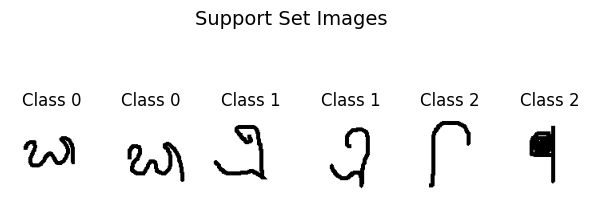

In [22]:
# Number of classes
num_classes = len(set(support_labels))

# Figure size
plt.figure(figsize=(num_classes * 2.5, 3))

# Iterate over support images and labels
for i, (img_path, label) in enumerate(zip(support_image_paths, support_labels)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    img = cv2.resize(img, (105, 105))  # Resize to Omniglot standard size

    plt.subplot(1, len(support_image_paths), i + 1)  # Arrange images in a row
    plt.imshow(img, cmap='gray')
    plt.title(f'Class {label}')
    plt.axis('off')

plt.suptitle("Support Set Images", fontsize=14)
plt.show()

In [23]:
# Manually selected paths for the query set (3 new images to classify)
query_image_paths = [

    # Class 2 images / Blackfoot
   "/kaggle/working/omniglot_data/images_background/Blackfoot_(Canadian_Aboriginal_Syllabics)/character04/0181_05.png",

   # Class 1 images / Bengali
   "/kaggle/working/omniglot_data/images_background/Bengali/character08/0139_03.png",


   # Class 0 images / Balinese
   "/kaggle/working/omniglot_data/images_background/Balinese/character01/0108_08.png"


]

## 📌 Step 5.2: Preparing Support Set and Query Set

In [24]:
def load_and_preprocess(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize to [0, 1]
    return image

def prepare_manual_support_set(support_image_paths, support_labels):
    support_images = [load_and_preprocess(img) for img in support_image_paths]
    support_images = np.stack(support_images)
    support_labels = np.array(support_labels)
    return support_images, support_labels

support_images, support_labels = prepare_manual_support_set(support_image_paths, support_labels)
print(f"Support Images Shape: {support_images.shape}, Labels Shape: {support_labels.shape}")


Support Images Shape: (6, 105, 105, 3), Labels Shape: (6,)


In [25]:
def prepare_query_images(query_image_paths):
    print(query_image_paths)
    query_images = [load_and_preprocess(img) for img in query_image_paths]
    return np.stack(query_images)

query_images = prepare_query_images(query_image_paths)
print(f"Query Images Shape: {query_images.shape}")


['/kaggle/working/omniglot_data/images_background/Blackfoot_(Canadian_Aboriginal_Syllabics)/character04/0181_05.png', '/kaggle/working/omniglot_data/images_background/Bengali/character08/0139_03.png', '/kaggle/working/omniglot_data/images_background/Balinese/character01/0108_08.png']
Query Images Shape: (3, 105, 105, 3)


## 📌 Step 5.3: Prediction on Query Set

In [26]:
def predict_query_image(siamese_net, query_image, support_images, support_labels):
    """
    Predict the class of a single query image by finding the closest support image.
    
    Args:
    - siamese_net: Trained Siamese network model.
    - query_image: A single image of shape (IMG_SIZE, IMG_SIZE, 3).
    - support_images: Support set images (NUM_SHOTS * NUM_WAYS, IMG_SIZE, IMG_SIZE, 3).
    - support_labels: Corresponding class labels for support images.

    Returns:
    - Predicted class label for the query image.
    """
    distances = []
    
    # Expand dimensions to match model input shape
    query_image = np.expand_dims(query_image, axis=0)  # Shape (1, IMG_SIZE, IMG_SIZE, 3)

    for i, support_image in enumerate(support_images):
        support_image = np.expand_dims(support_image, axis=0)  # Shape (1, IMG_SIZE, IMG_SIZE, 3)

        # Predict distance using the Siamese network
        distance = siamese_net.predict([query_image, support_image])[0][0]
        print('distance:', distance)
        distances.append((distance, support_labels[i]))

    # Find the support image with the smallest distance
    distances.sort()  # Sort by distance (ascending)
    best_match_label = distances[0][1]  # Get the class of the closest match

    return best_match_label, distances  # Returning distances for debugging


In [27]:
predicted_labels = []

for i, query_image in enumerate(query_images):
    predicted_label, distances = predict_query_image(siamese_net, query_image, support_images, support_labels)
    predicted_labels.append(predicted_label)
    print(f"Query Image {i+1} classified as Class {predicted_label}, Distances: {distances}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
distance: 0.7840795
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
distance: 0.51355535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
distance: 0.4068686
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
distance: 0.4288937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
distance: 0.21243635
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
distance: 0.2795225
Query Image 1 classified as Class 2, Distances: [(0.21243635, 2), (0.2795225, 2), (0.4068686, 1), (0.4288937, 1), (0.51355535, 0), (0.7840795, 0)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
distance: 0.707376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
distance: 0.37025982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
distance: 0.12405947
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
distance: 0.3187257
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
distance: 0.43446338
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
distance: 0.33084786
Query Image 2 classified as Class 1, Distances: [(0.12405947, 1), (0.3187257, 1), (0.33084786, 2), (0.37025982, 0), (0.43446338, 2), (0.707376, 0)]
1/1 ━━

In [28]:
print("Predicted Labels for Query Set:", predicted_labels)

Predicted Labels for Query Set: [2, 1, 0]


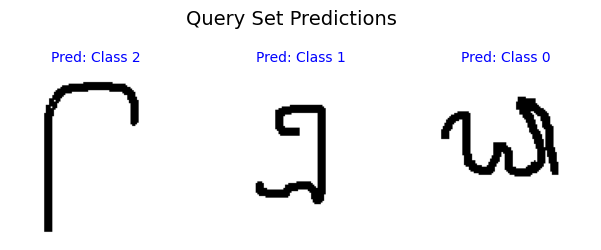

In [29]:
# Number of query images
num_queries = len(query_image_paths)

# Set up figure size dynamically
plt.figure(figsize=(num_queries * 2.5, 3))

# Iterate over query images and their predicted labels
for i, (img_path, predicted_label) in enumerate(zip(query_image_paths, predicted_labels)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
    img = cv2.resize(img, (105, 105))  # Resize to match Omniglot standard size

    plt.subplot(1, num_queries, i + 1)  # Create subplot for each query image
    plt.imshow(img, cmap='gray')
    plt.title(f'Pred: Class {predicted_label}', fontsize=10, color='blue')  # Show predicted label
    plt.axis('off')

plt.suptitle("Query Set Predictions", fontsize=14)
plt.show()